# Multimodal Sentiment Model

In [17]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import h5py
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

## Model Definition

In [18]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, encoding_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [19]:
class MultimodalSentimentModel(nn.Module):
    def __init__(self, audio_feature_dim, facial_feature_dim, text_feature_dim, encoding_dim, output_dim, dropout_rate=0):
        super(MultimodalSentimentModel, self).__init__()
        
        total_feature_dim = encoding_dim * 3

        self.fc = nn.Linear(encoding_dim, output_dim)

        self.face_autoencoder = Autoencoder(input_dim=facial_feature_dim, encoding_dim=encoding_dim)
        self.text_autoencoder = Autoencoder(input_dim=text_feature_dim, encoding_dim=encoding_dim)
        self.audio_autoencoder = Autoencoder(input_dim=audio_feature_dim, encoding_dim=encoding_dim)
        self.concat_autoencoder = Autoencoder(input_dim=total_feature_dim, encoding_dim=encoding_dim)
        
        self.dropout = nn.Dropout(dropout_rate)


    def forward(self, audio_features, facial_features, text_features):
        text_encoded, _ = self.text_autoencoder(text_features)
        face_encoded, _ = self.face_autoencoder(facial_features)
        audio_encoded, _ = self.audio_autoencoder(audio_features)
        combined_features = torch.cat((audio_encoded, face_encoded, text_encoded), dim=1)
        concat_features, _ = self.concat_autoencoder(combined_features)
        x = F.relu(self.fc(concat_features))
        x = self.dropout(x)

        
        return x

## Dataset Definition

In [20]:
class MultimodalDataset(Dataset):
    def __init__(self, h5_file, split='train'):
        self.h5_file_path = h5_file
        self.split = split
        self.groups = []
        self.file = None
        self.open_file()
        
        # Error handling for file opening
        if self.file is not None:
            self.collect_groups()

    def open_file(self):
        try:
            self.file = h5py.File(self.h5_file_path, 'r')
        except Exception as e:
            print(f"Failed to open file {self.h5_file_path}: {e}")

    def collect_groups(self):
        for group_name in self.file:
            if self.file[group_name].attrs['split'] == self.split:
                self.groups.append(group_name)
                
    def __len__(self):
        return len(self.groups)

    def __getitem__(self, idx):
        if self.file is None:
            print("HDF5 file is not opened.")
            return None
        
        try:
            group = self.file[self.groups[idx]]
            
            audio_features = torch.tensor(group['audio_features_averaged'][:], dtype=torch.float32)
            facial_features = torch.tensor(group['averaged_facial_features'][:], dtype=torch.float32)
            text_features = torch.tensor(group['bert_text_features_512'][:], dtype=torch.float32)
            
            label_mapping = {'Negative': 0, 'Neutral': 1, 'Positive': 2}
            label = torch.tensor(label_mapping[group.attrs['label']], dtype=torch.long)

            return audio_features, facial_features, text_features, label
        except Exception as e:
            print(f"Error loading data point {idx}: {e}")
            # Return None or raise an exception if preferred
            return None

    def __del__(self):
        if self.file is not None:
            self.file.close()
            print("HDF5 file closed.")
    

def create_dataloaders(h5_file, batch_size=64):
    train_dataset = MultimodalDataset(h5_file, 'train')
    validate_dataset = MultimodalDataset(h5_file, 'validate')
    test_dataset = MultimodalDataset(h5_file, 'test')

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

    return train_loader, validate_loader, test_loader

def print_loader_sizes(train_loader, validate_loader, test_loader):
    # Calculate number of batches in each loader
    num_train_batches = len(train_loader)
    num_validate_batches = len(validate_loader)
    num_test_batches = len(test_loader)

    # Print the total number of batches for each loader
    print(f"Total number of batches in Train Loader: {num_train_batches}")
    print(f"Total number of batches in Validate Loader: {num_validate_batches}")
    print(f"Total number of batches in Test Loader: {num_test_batches}")

    # To verify the size of the first batch (optional)
    # Here we use a trick to get the first batch without iterating through the DataLoader
    first_batch_train = next(iter(train_loader))
    print(f"Shapes of the first train batch - Audio Features: {first_batch_train[0].shape}, Facial Features: {first_batch_train[1].shape}, Text Features: {first_batch_train[2].shape}, Labels: {first_batch_train[3].shape}")

    first_batch_validate = next(iter(validate_loader))
    print(f"Shapes of the first validate batch - Audio Features: {first_batch_validate[0].shape}, Facial Features: {first_batch_validate[1].shape}, Text Features: {first_batch_validate[2].shape}, Labels: {first_batch_validate[3].shape}")

    first_batch_test = next(iter(test_loader))
    print(f"Shapes of the first test batch - Audio Features: {first_batch_test[0].shape}, Facial Features: {first_batch_test[1].shape}, Text Features: {first_batch_test[2].shape}, Labels: {first_batch_test[3].shape}")


## Training functions

In [21]:
def save_checkpoint(model, optimizer, epoch, filepath):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, filepath)

def load_checkpoint(filepath, model, optimizer):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    return model, optimizer, epoch


In [22]:
def train(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss = 0
    correct_predictions = 0

    for audio_features, facial_features, text_features, labels in tqdm(dataloader):
        audio_features = audio_features.to(device)
        facial_features = facial_features.to(device)
        text_features = text_features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(audio_features, facial_features, text_features)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)
    return avg_loss, accuracy

def validate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for audio_features, facial_features, text_features, labels in tqdm(dataloader):
            audio_features = audio_features.to(device)
            facial_features = facial_features.to(device)
            text_features = text_features.to(device)
            labels = labels.to(device)

            outputs = model(audio_features, facial_features, text_features)
            loss = loss_fn(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct_predictions / len(dataloader.dataset)
    return avg_loss, accuracy

def train_and_validate(model, optimizer,train_loader, validate_loader, num_epochs, device, learning_rate):
    loss_fn = nn.CrossEntropyLoss()

    training_losses = []
    validation_losses = []
    last_epoch_with_lower_val_loss = 0  # Track the last epoch where validation loss < training loss

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = train(model, train_loader, loss_fn, optimizer, device)
        val_loss, val_accuracy = validate(model, validate_loader, loss_fn, device)
        training_losses.append(train_loss)
        validation_losses.append(val_loss)

        if val_loss == min(validation_losses):
            last_epoch_with_lower_val_loss = epoch  # Update if current epoch meets condition
            save_checkpoint(model, optimizer, epoch, f'mmsa_best.pth')  # Save the best model so far

        print(f'Epoch {epoch}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}')
        
        # Save the model checkpoint for every epoch as well
        save_checkpoint(model, optimizer, epoch, f'mmsa_{epoch}.pth')

    return training_losses, validation_losses, last_epoch_with_lower_val_loss

def plot_losses(training_losses, validation_losses):
    epochs = range(1, len(training_losses) + 1)  # Start epochs at 1
    plt.plot(epochs, training_losses, label='Training Loss')
    plt.plot(epochs, validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.xticks(epochs)  # Ensure x-ticks correspond to epochs
    plt.legend()
    plt.show()

def test(model, test_loader, device, epoch):

    test_loss, test_accuracy = validate(model, test_loader, nn.CrossEntropyLoss(), device)
    print(f'Epoch {epoch} Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

## Execution

In [23]:
# Hyperparams
batch_size = 64
num_epochs = 20
audio_feature_dim = 45 
facial_feature_dim = 2048 
text_feature_dim = 768 
encoding_dim = 512

learning_rate = 1e-5
dropout_rate = 0.1

# Other definitions
h5_file = r'combined_features.h5'
output_dim = 3  

HDF5 file closed.
HDF5 file closed.
HDF5 file closed.


100%|██████████| 22/22 [00:00<00:00, 52.00it/s]


Epoch 1, Train Loss: 1.0981427835205855, Train Accuracy: 0.34837337115503947, Val Loss: 1.0973439324985852, Val Accuracy: 0.3421240199572345


100%|██████████| 22/22 [00:00<00:00, 55.69it/s]


Epoch 2, Train Loss: 1.094885740576491, Train Accuracy: 0.37301657654463255, Val Loss: 1.0915603800253435, Val Accuracy: 0.36564504632929434


100%|██████████| 22/22 [00:00<00:00, 53.26it/s]


Epoch 3, Train Loss: 1.0797111274158888, Train Accuracy: 0.41060189699494726, Val Loss: 1.05673547224565, Val Accuracy: 0.5160370634354954


100%|██████████| 22/22 [00:00<00:00, 55.79it/s]


Epoch 4, Train Loss: 0.9969101561664861, Train Accuracy: 0.54020033684957, Val Loss: 0.9225954603065144, Val Accuracy: 0.6058446186742694


100%|██████████| 22/22 [00:00<00:00, 54.59it/s]


Epoch 5, Train Loss: 0.8969099299382355, Train Accuracy: 0.5868274089176492, Val Loss: 0.8534230589866638, Val Accuracy: 0.6186742694226657


100%|██████████| 22/22 [00:00<00:00, 53.01it/s]


Epoch 6, Train Loss: 0.8574715613645348, Train Accuracy: 0.6048222675294743, Val Loss: 0.8216107325120405, Val Accuracy: 0.6372059871703493


100%|██████████| 22/22 [00:00<00:00, 55.55it/s]


Epoch 7, Train Loss: 0.8344316674491107, Train Accuracy: 0.6187394734509352, Val Loss: 0.8096944229169325, Val Accuracy: 0.6336421952957947


100%|██████████| 22/22 [00:00<00:00, 56.46it/s]


Epoch 8, Train Loss: 0.8169826050262666, Train Accuracy: 0.6257423987235174, Val Loss: 0.8002547540447928, Val Accuracy: 0.6429080541696365


100%|██████████| 22/22 [00:00<00:00, 54.32it/s]


Epoch 9, Train Loss: 0.8076252284023048, Train Accuracy: 0.6338977041042461, Val Loss: 0.7923271601850336, Val Accuracy: 0.6507483962936564


100%|██████████| 22/22 [00:00<00:00, 56.70it/s]


Epoch 10, Train Loss: 0.8029949146475496, Train Accuracy: 0.6354046627072069, Val Loss: 0.7930795198137109, Val Accuracy: 0.6600142551674982


100%|██████████| 22/22 [00:00<00:00, 53.98it/s]


Epoch 11, Train Loss: 0.7953568393901244, Train Accuracy: 0.639305026150164, Val Loss: 0.7870263674042441, Val Accuracy: 0.6535994297933001


100%|██████████| 22/22 [00:00<00:00, 56.03it/s]


Epoch 12, Train Loss: 0.7841444295004937, Train Accuracy: 0.6493218686286677, Val Loss: 0.7832369614731182, Val Accuracy: 0.6607270135424091


100%|██████████| 22/22 [00:00<00:00, 55.13it/s]


Epoch 13, Train Loss: 0.7728636382663318, Train Accuracy: 0.6496764471234819, Val Loss: 0.7824420739303936, Val Accuracy: 0.6514611546685674


100%|██████████| 22/22 [00:00<00:00, 56.40it/s]


Epoch 14, Train Loss: 0.768775147570055, Train Accuracy: 0.6523357858345892, Val Loss: 0.785768601027402, Val Accuracy: 0.6464718460441911


100%|██████████| 22/22 [00:00<00:00, 54.38it/s]


Epoch 15, Train Loss: 0.7589128566327068, Train Accuracy: 0.6604910912153178, Val Loss: 0.7795544727282091, Val Accuracy: 0.6635780470420527


100%|██████████| 22/22 [00:00<00:00, 57.18it/s]


Epoch 16, Train Loss: 0.7517583767573038, Train Accuracy: 0.661909405194575, Val Loss: 0.7809119847687808, Val Accuracy: 0.6507483962936564


100%|██████████| 22/22 [00:00<00:00, 56.21it/s]


Epoch 17, Train Loss: 0.7398482214259563, Train Accuracy: 0.6722808261678929, Val Loss: 0.7791678986766122, Val Accuracy: 0.6571632216678546


100%|██████████| 22/22 [00:00<00:00, 58.33it/s]


Epoch 18, Train Loss: 0.7287379439267735, Train Accuracy: 0.6786632390745502, Val Loss: 0.7760665768926794, Val Accuracy: 0.654312188168211


100%|██████████| 22/22 [00:00<00:00, 56.32it/s]


Epoch 19, Train Loss: 0.7247862896676791, Train Accuracy: 0.6829181810123216, Val Loss: 0.7797007181427695, Val Accuracy: 0.6528866714183892


100%|██████████| 22/22 [00:00<00:00, 57.06it/s]


Epoch 20, Train Loss: 0.719851687129608, Train Accuracy: 0.6785745944508466, Val Loss: 0.7721097821539099, Val Accuracy: 0.6614397719173201


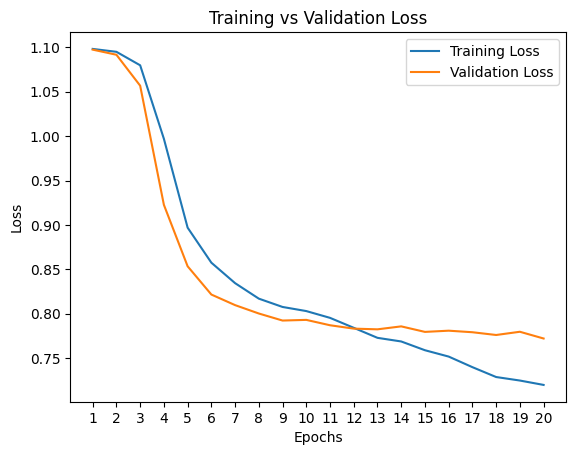

Testing the model from epoch 20


100%|██████████| 23/23 [00:00<00:00, 46.58it/s]

Epoch 20 Test Loss: 0.7938612518103226, Test Accuracy: 0.65


In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultimodalSentimentModel(
    audio_feature_dim=audio_feature_dim,
    facial_feature_dim=facial_feature_dim,
    text_feature_dim=text_feature_dim,
    encoding_dim=encoding_dim,
    output_dim=output_dim,
    dropout_rate=dropout_rate
).to(device)

optimizer = Adam(model.parameters(), lr=learning_rate)

train_loader, validate_loader, test_loader = create_dataloaders(h5_file, batch_size)
# print_loader_sizes(train_loader, validate_loader, test_loader)

training_losses, validation_losses, last_epoch_with_lower_val_loss  = train_and_validate(model, optimizer, train_loader, validate_loader, num_epochs, device, learning_rate)
plot_losses(training_losses, validation_losses)

if last_epoch_with_lower_val_loss > 0:
    best_model_path = f'mmsa_best.pth'
    model, optimizer, _ = load_checkpoint(best_model_path, model, optimizer)
    print(f"Testing the model from epoch {last_epoch_with_lower_val_loss}")
    test(model, test_loader, device, last_epoch_with_lower_val_loss)
else:
    print("No epoch where the validation loss was lower than the training loss was found.")